In [95]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [97]:
# https://www.kaggle.com/yashmehta648/song-popularity-prediction/

In [64]:
import joblib
import random
import warnings

from tqdm.notebook import tqdm
from IPython.core import pylabtools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor

set_config(display='diagram')
pylabtools.figsize(16, 8)
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [3]:
random.seed(0)
np.random.seed(0)

In [4]:
# !7z l "../Data/song_data.csv.zip"

In [5]:
# !7z x "../Data/song_data.csv.zip" -o"../Data"

In [6]:
df = pd.read_csv("../Data/song_data.csv")
df

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
song_popularity,18835.0,52.991877,21.905654,0.000000,40.0000,56.000000,69.00000,100.000
song_duration_ms,18835.0,218211.587576,59887.540566,12000.000000,184339.5000,211306.000000,242844.00000,1799346.000
acousticness,18835.0,0.258539,0.288719,0.000001,0.0241,0.132000,0.42400,0.996
danceability,18835.0,0.633348,0.156723,0.000000,0.5330,0.645000,0.74800,0.987
energy,18835.0,0.644995,0.214101,0.001070,0.5100,0.674000,0.81500,0.999
instrumentalness,18835.0,0.078008,0.221591,0.000000,0.0000,0.000011,0.00257,0.997
key,18835.0,5.289196,3.614595,0.000000,2.0000,5.000000,8.00000,11.000
liveness,18835.0,0.179650,0.143984,0.010900,0.0929,0.122000,0.22100,0.986
loudness,18835.0,-7.447435,3.827831,-38.768000,-9.0440,-6.555000,-4.90800,1.585
audio_mode,18835.0,0.628139,0.483314,0.000000,0.0000,1.000000,1.00000,1.000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [9]:
df.drop('song_name', axis=1, inplace=True)

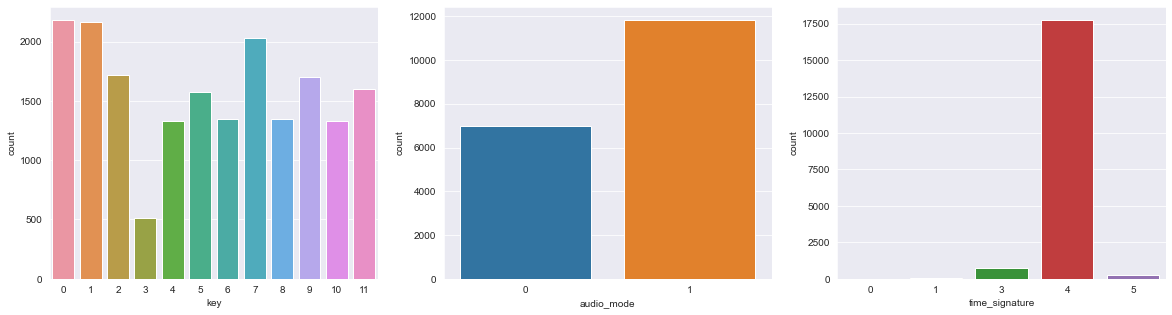

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

for i, int_c in enumerate(['key', 'audio_mode', 'time_signature']):
    sns.countplot(x=int_c, data=df, ax=axs[i])

In [11]:
df.columns

Index(['song_popularity', 'song_duration_ms', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness',
       'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

<AxesSubplot:xlabel='song_duration_ms', ylabel='Density'>

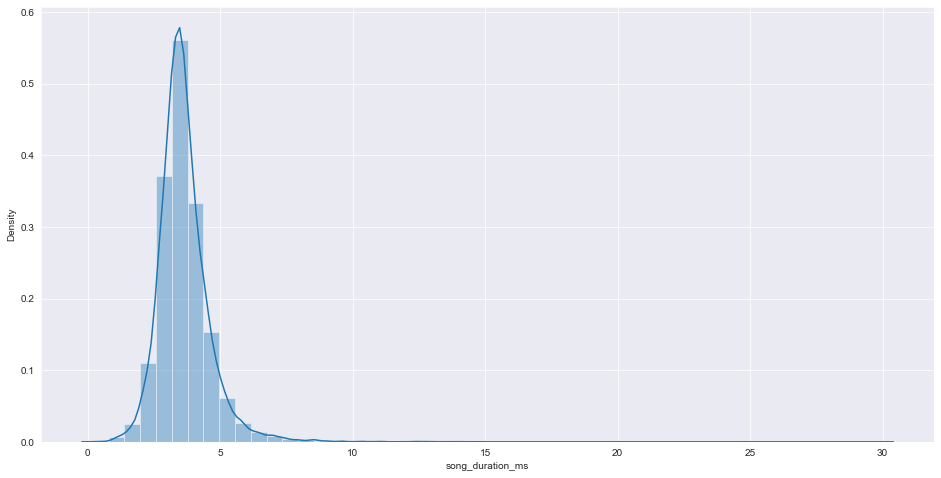

In [12]:
sns.distplot(df['song_duration_ms']/60000)

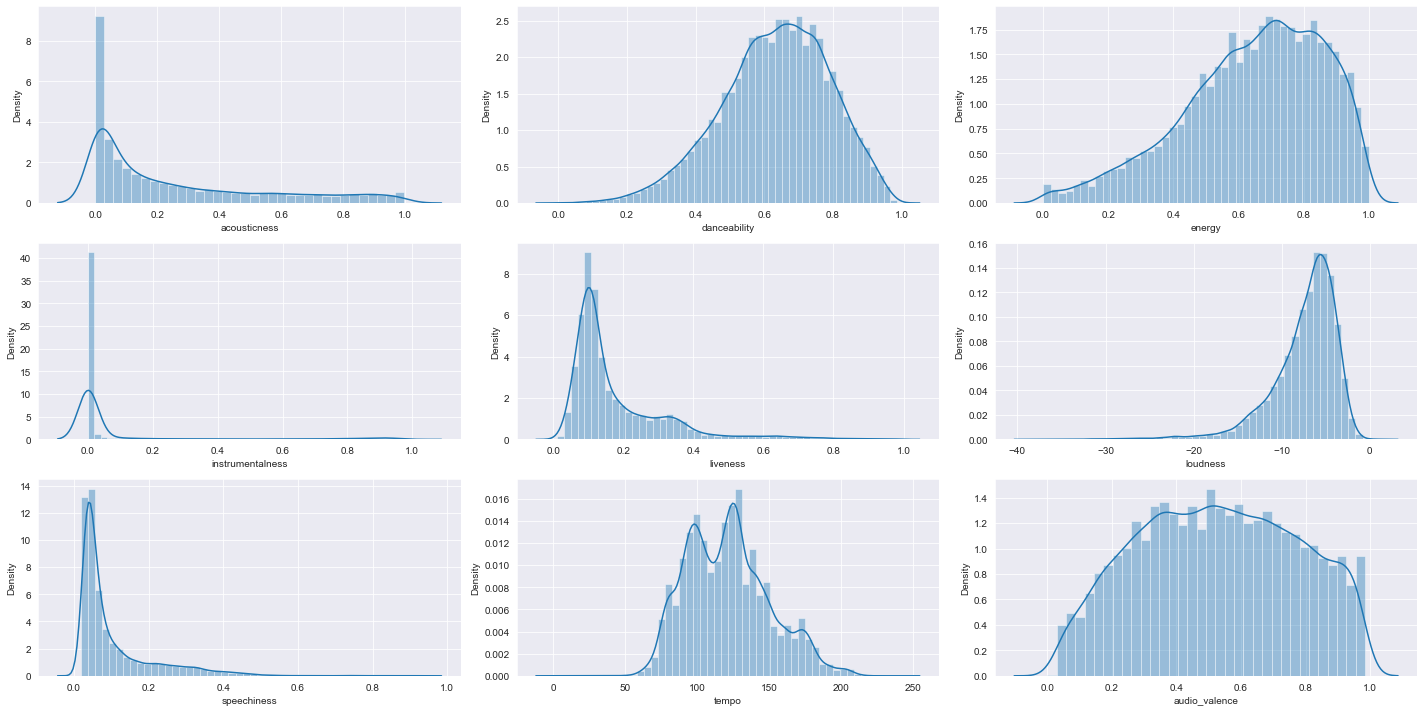

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

for i, float_c in enumerate(df.select_dtypes('float').columns):
    sns.distplot(df[float_c], kde=True, ax=axs[i//3][i%3])
    
fig.tight_layout()

<AxesSubplot:>

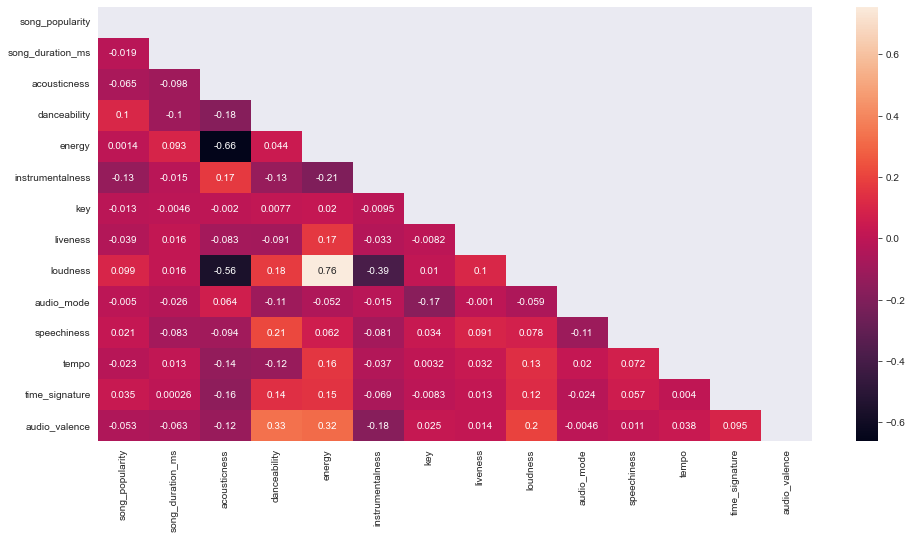

In [14]:
corr = df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True)

<AxesSubplot:xlabel='song_popularity', ylabel='count'>

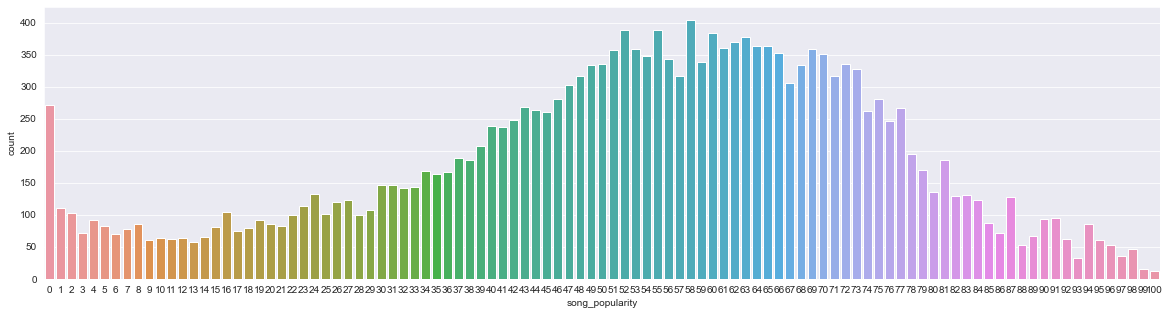

In [15]:
plt.figure(figsize=(20, 5))
sns.countplot(x='song_popularity', data=df)

In [16]:
X = df.loc[:, df.columns != 'song_popularity']
y = df['song_popularity']

In [17]:
X.columns

Index(['song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
       'speechiness', 'tempo', 'time_signature', 'audio_valence'],
      dtype='object')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
quantile_transform_columns = [
    'song_duration_ms', 'time_signature', 'acousticness',
    'instrumentalness', 'liveness', 'loudness', 'speechiness'
]
min_max_scale_columns = [
    'danceability', 'energy', 'key', 'audio_mode', 'tempo', 'audio_valence'
]

In [20]:
pipeline = Pipeline([
    ("column_transformer", ColumnTransformer(
        transformers=[
            (
                "quantile_transform",
                QuantileTransformer(),
                quantile_transform_columns
            ),
            (
                "minmax_scale",
                MinMaxScaler(),
                min_max_scale_columns
            )
        ],
        remainder='drop',
        n_jobs=-1
    )),
    ("feature_selection", SelectFromModel(RandomForestRegressor(n_jobs=-1))),
    ("regressor", TransformedTargetRegressor(
        regressor=StackingRegressor(
            estimators=[
                ("extra_trees", ExtraTreesRegressor(n_jobs=-1)),
                ("light_gbm", LGBMRegressor(n_jobs=-1)),
            ],
            final_estimator=ElasticNet()
        ),
        transformer=FunctionTransformer(inverse_func=np.round)
    )),
])

In [21]:
pipeline

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('quantile_transform',
                                                  QuantileTransformer(),
                                                  ['song_duration_ms',
                                                   'time_signature',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness']),
                                                 ('minmax_scale',
                                                  MinMaxScaler(),
                                                  ['danceability', 'energy',
                                                   'key', 'audio_mode', 'tempo',
                                                   'audio_valence'])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(n_jobs=-1))),
                ('regressor',
                 TransformedTargetRegressor(regressor=StackingRegressor(estimators=[('extra_trees',
                                                                                     ExtraTreesRegressor(n_jobs=-1)),
                                                                                    ('light_gbm',
                                                                                     LGBMRegressor())],
                                                                        final_estimator=ElasticNet()),
                                            transformer=FunctionTransformer(inverse_func=<function round_ at 0x000001B592C74F70>)))])

In [24]:
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, n_jobs=-1, verbose=2)

[learning_curve] Training set sizes: [ 1130  3672  6215  8757 11300]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  1.6min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.8min finished


[Text(0.5, 0, 'Sizes'), Text(0, 0.5, 'Scores'), Text(0.5, 1.0, 'Model')]

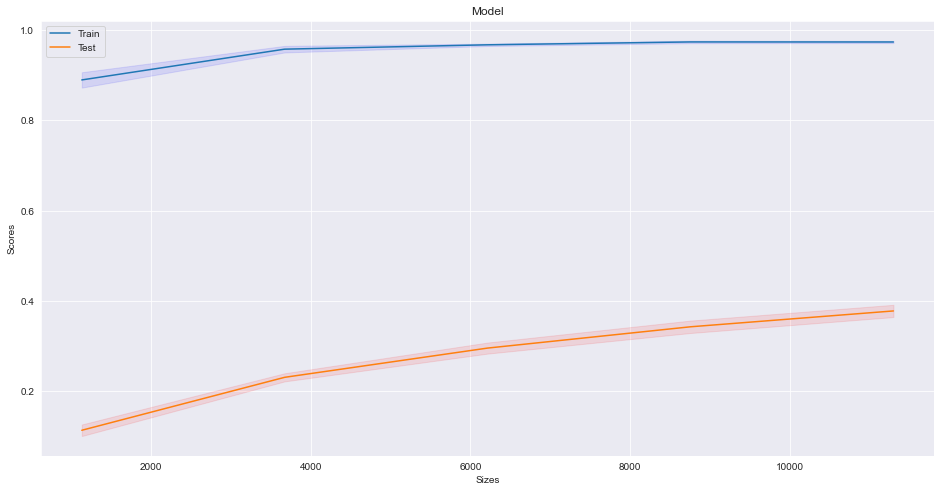

In [25]:
# mean scores and std
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)
train_score_std = np.std(train_scores, axis=1)
test_score_std = np.std(test_scores, axis=1)


# train score and confidence interval
ax = sns.lineplot(x=train_sizes, y=train_score_mean, label='Train')
ax.fill_between(
    train_sizes,
    train_score_mean - train_score_std,
    train_score_mean + train_score_std,
    alpha=0.1,
    color="b",
)

# test score and confidence interval
sns.lineplot(x=train_sizes, y=test_score_mean, label='Test', ax=ax)
ax.fill_between(
    train_sizes,
    test_score_mean - test_score_std,
    test_score_mean + test_score_std,
    alpha=0.1,
    color="r",
)

ax.set(xlabel="Sizes", ylabel="Scores", title="Model")

In [28]:
list(name for name in pipeline.get_params().keys() if "extra_trees__" in name or "light_gbm__" in name)

['regressor__regressor__extra_trees__bootstrap',
 'regressor__regressor__extra_trees__ccp_alpha',
 'regressor__regressor__extra_trees__criterion',
 'regressor__regressor__extra_trees__max_depth',
 'regressor__regressor__extra_trees__max_features',
 'regressor__regressor__extra_trees__max_leaf_nodes',
 'regressor__regressor__extra_trees__max_samples',
 'regressor__regressor__extra_trees__min_impurity_decrease',
 'regressor__regressor__extra_trees__min_samples_leaf',
 'regressor__regressor__extra_trees__min_samples_split',
 'regressor__regressor__extra_trees__min_weight_fraction_leaf',
 'regressor__regressor__extra_trees__n_estimators',
 'regressor__regressor__extra_trees__n_jobs',
 'regressor__regressor__extra_trees__oob_score',
 'regressor__regressor__extra_trees__random_state',
 'regressor__regressor__extra_trees__verbose',
 'regressor__regressor__extra_trees__warm_start',
 'regressor__regressor__light_gbm__boosting_type',
 'regressor__regressor__light_gbm__class_weight',
 'regressor_

In [35]:
param_grid = {
    "regressor__regressor__extra_trees__max_depth": [50, 100],
    "regressor__regressor__extra_trees__n_estimators": [50, 100],
    "regressor__regressor__light_gbm__max_depth": [50, 100],
    "regressor__regressor__light_gbm__n_estimators": [50, 100],
}

In [37]:
gscv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=4, shuffle=True),
    verbose=2
).fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


In [38]:
gscv.best_params_

{'regressor__regressor__extra_trees__max_depth': 50,
 'regressor__regressor__extra_trees__n_estimators': 100,
 'regressor__regressor__light_gbm__max_depth': 50,
 'regressor__regressor__light_gbm__n_estimators': 100}

In [63]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__regressor__extra_trees__max_depth,param_regressor__regressor__extra_trees__n_estimators,param_regressor__regressor__light_gbm__max_depth,param_regressor__regressor__light_gbm__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,27.706258,1.795395,2.653261,2.574039,50,50,50,50,{'regressor__regressor__extra_trees__max_depth...,0.356271,0.381376,0.372047,0.365518,0.368803,0.009171,9
1,26.093619,0.772132,1.856287,1.154157,50,50,50,100,{'regressor__regressor__extra_trees__max_depth...,0.351281,0.379634,0.372665,0.358537,0.365529,0.011200,12
2,24.973463,1.613667,2.122144,1.042676,50,50,100,50,{'regressor__regressor__extra_trees__max_depth...,0.355430,0.370624,0.372049,0.356157,0.363565,0.007792,15
3,25.549611,1.705812,2.406814,0.798832,50,50,100,100,{'regressor__regressor__extra_trees__max_depth...,0.349038,0.378161,0.368360,0.358887,0.363612,0.010828,14
4,36.354891,1.035076,1.783979,0.257064,50,100,50,50,{'regressor__regressor__extra_trees__max_depth...,0.356055,0.380777,0.375454,0.365262,0.369387,0.009504,6
5,39.033242,0.485674,1.514949,0.470966,50,100,50,100,{'regressor__regressor__extra_trees__max_depth...,0.360707,0.383685,0.375606,0.363621,0.370905,0.009253,1
6,37.886492,0.795686,1.316230,0.137572,50,100,100,50,{'regressor__regressor__extra_trees__max_depth...,0.359858,0.380838,0.373007,0.365582,0.369821,0.007886,3
7,39.506935,0.561079,1.347396,0.681937,50,100,100,100,{'regressor__regressor__extra_trees__max_depth...,0.357374,0.381786,0.375144,0.364688,0.369748,0.009391,4
8,26.324933,0.341249,2.579884,1.928664,100,50,50,50,{'regressor__regressor__extra_trees__max_depth...,0.354683,0.377155,0.374183,0.354881,0.365225,0.010497,13
9,26.123986,1.232970,3.094225,2.132265,100,50,50,100,{'regressor__regressor__extra_trees__max_depth...,0.352921,0.373421,0.371409,0.355043,0.363198,0.009274,16


In [39]:
best_model = gscv.best_estimator_

In [40]:
pred = best_model.predict(X_test)

In [41]:
print(f"MAE : {mean_absolute_error(y_test, pred)}")
print(f"RMSE : {mean_squared_error(y_test, pred, squared=False)}")
print(f"R2 Score : {r2_score(y_test, pred)}")

MAE : 12.095774049692078
RMSE : 17.1267060554575
R2 Score : 0.4001055008164387


In [42]:
print(pred)
print(y_test.to_numpy())

[46. 83. 56. ... 52. 41. 94.]
[37 87 43 ... 53  5 97]


In [55]:
train_pred = best_model.predict(X_train)

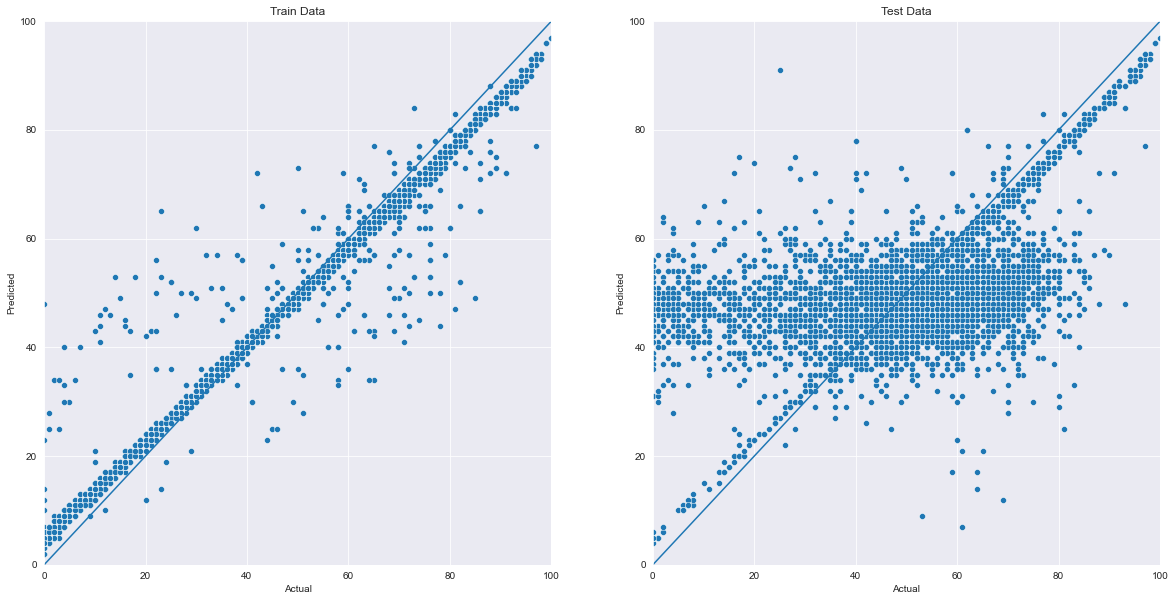

In [60]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))

sns.scatterplot(x=y_train, y=train_pred, ax=axs[0]).set(
    xlabel="Actual", ylabel="Predicted", xlim=(0,100), ylim=(0,100), title='Train Data'
)
axs[0].plot([0, 100], [0, 100])

sns.scatterplot(x=y_test, y=pred, ax=axs[1]).set(
    xlabel="Actual", ylabel="Predicted", xlim=(0,100), ylim=(0,100), title='Test Data'
)
axs[1].plot([0, 100], [0, 100])

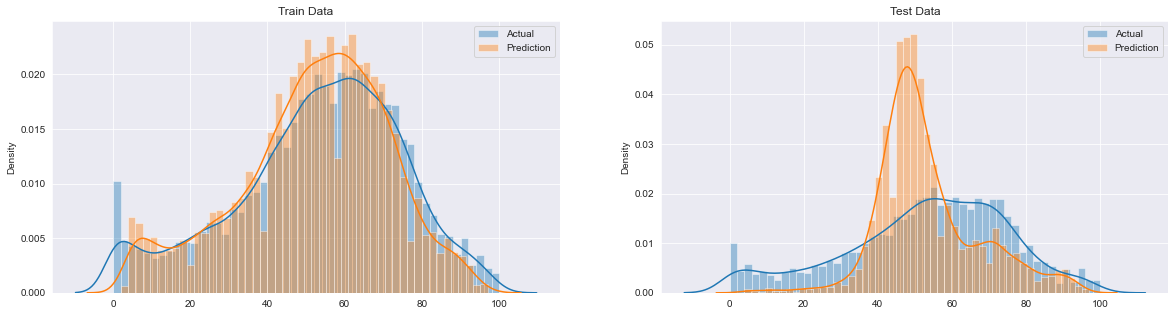

In [98]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x=y_train, bins=50, label='Actual', ax=axs[0])
sns.distplot(x=train_pred.astype('int'), bins=50, label='Prediction', ax=axs[0])
axs[0].set_title("Train Data")
axs[0].legend()

sns.distplot(x=y_test, bins=50, label='Actual', ax=axs[1])
sns.distplot(x=pred.astype('int'), bins=50, label='Prediction', ax=axs[1])
axs[1].set_title("Test Data")
axs[1].legend()

In [99]:
joblib.dump(best_model, "../Data/song_popularity_pred.pkl")

['../Data/song_popularity_pred.pkl']